In [1]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, Concatenate
from tensorflow.keras.callbacks import Callback
from keras.layers import Dropout
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

In [2]:
# load data
data_path = './data/ml-latest-small/'
df = pd.read_csv(data_path+'ratings.csv')

In [3]:
df

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [4]:
# binary implicit feedback
# rating >= 3.0 --> positive
df['rating'] = df['rating'].apply(lambda x: 1 if x >=3.0 else 0)

# total number of users and total number of movies
n_users = df.userId.unique()
n_movies = df.movieId.unique()

# train valid split
train, validation = train_test_split(df, test_size=0.2, random_state=42)

# user id indexing
unique_user_ids = df["userId"].unique()
userId_dict = {id: i for i, id in enumerate(unique_user_ids)}

# movie id indexing
unique_movie_ids = df['movieId'].unique()
movieId_dict = {id: i for i, id in enumerate(unique_movie_ids)}

# mapping ID using indexed dictionary
train['userId'] = train['userId'].map(userId_dict)
train['movieId'] = train['movieId'].map(movieId_dict)

validation['userId'] = validation['userId'].map(userId_dict)
validation['movieId'] = validation['movieId'].map(movieId_dict)

# total number of unique users
num_unique_users = df['userId'].nunique() + 1
num_unique_movies = df['movieId'].nunique() + 1

In [5]:
# user / item input layer
user_input = Input(shape=(1, ))
movie_input = Input(shape=(1, ))

# embedding dimension
n_latent_factors = 20

# embedding layers
user_embedding = Embedding(num_unique_users, n_latent_factors, name='user_embedding')(user_input)
movie_embedding = Embedding(num_unique_movies, n_latent_factors, name='movie_embedding')(movie_input)

# flatten layer
user_vector = Flatten()(user_embedding)
movie_vector = Flatten()(movie_embedding)

# concatenate user vector and movie vector
concat = Concatenate()([user_vector, movie_vector])

In [6]:
# MLP function
def create_mlp(hidden_layers, output):
    for i in range(len(hidden_layers)):
        if i == 0:
            hidden = Dense(hidden_layers[i], activation='relu')(output)
        else:
            hidden = Dense(hidden_layers[i], activation='relu')(hidden)
            
    output = Dense(1, activation='sigmoid')(hidden)     # activation for binary output is sigmoid
    return output 
            

In [7]:
# create an MLP model
output = create_mlp([64, 64], concat)

In [8]:
# the final model
model = Model(inputs=[user_input, movie_input], outputs=output)

In [9]:
# compile the model -> evaluate by auc
auc = tf.keras.metrics.AUC()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auc])

In [10]:
# 모델 요약
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 20)     │     12,220 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 20)     │    194,500 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 20)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 20)        │          0 │ movie_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 40)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      2,624 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      4,160 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 213,569 (834.25 KB)

 Trainable params: 213,569 (834.25 KB)

 Non-trainable params: 0 (0.00 B)

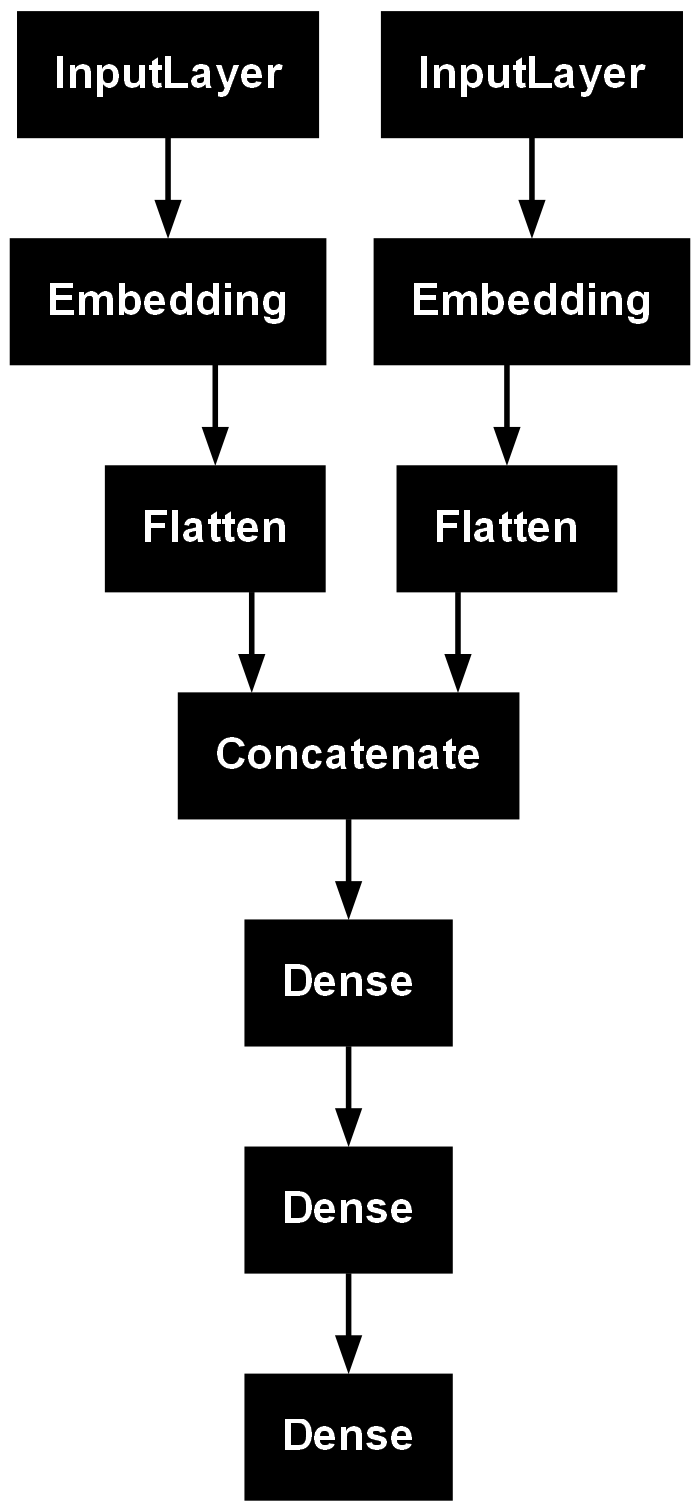

In [11]:
tf.keras.utils.plot_model(model)

In [12]:
train.movieId.head(10)

80568    4285
50582    5629
8344      134
99603      66
71701    1172
95405    5162
13938    3913
52544     147
64437    2289
22977    1682
Name: movieId, dtype: int64

In [13]:
# fit the model
history = model.fit(
    x=[train.userId, train.movieId],
    y=train.rating,
    epochs=10, verbose=2,
    validation_data=([validation.userId, validation.movieId], validation.rating)
)

Epoch 1/10


d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_1']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2521/2521 - 3s - 1ms/step - accuracy: 0.8259 - auc: 0.7698 - loss: 0.4081 - val_accuracy: 0.8286 - val_auc: 0.7973 - val_loss: 0.3932
Epoch 2/10
2521/2521 - 2s - 734us/step - accuracy: 0.8492 - auc: 0.8436 - loss: 0.3514 - val_accuracy: 0.8287 - val_auc: 0.7976 - val_loss: 0.3971
Epoch 3/10
2521/2521 - 2s - 745us/step - accuracy: 0.8640 - auc: 0.8698 - loss: 0.3221 - val_accuracy: 0.8289 - val_auc: 0.7951 - val_loss: 0.4080
Epoch 4/10
2521/2521 - 2s - 737us/step - accuracy: 0.8736 - auc: 0.8888 - loss: 0.2998 - val_accuracy: 0.8248 - val_auc: 0.7848 - val_loss: 0.4261
Epoch 5/10
2521/2521 - 2s - 730us/step - accuracy: 0.8823 - auc: 0.9049 - loss: 0.2786 - val_accuracy: 0.8196 - val_auc: 0.7843 - val_loss: 0.4388
Epoch 6/10
2521/2521 - 2s - 730us/step - accuracy: 0.8927 - auc: 0.9200 - loss: 0.2564 - val_accuracy: 0.8130 - val_auc: 0.7720 - val_loss: 0.4760
Epoch 7/10
2521/2521 - 2s - 724us/step - accuracy: 0.9026 - auc: 0.9348 - loss: 0.2324 - val_accuracy: 0.8074 - val_auc: 0.7692 - v

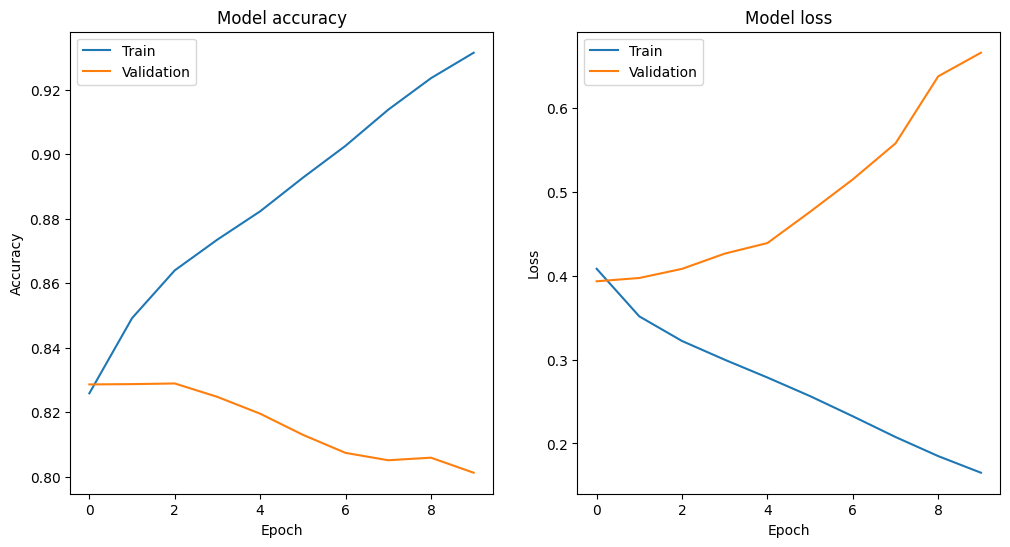

In [14]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 6))

# plot traininig & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [15]:
# 유저/아이템 입력 레이어
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

# 임베딩 차원
n_latent_factors = 20

# 임베딩 레이어 정의
user_embedding = Embedding(num_unique_users, n_latent_factors, name='user_embedding')(user_input)
movie_embedding = Embedding(num_unique_movies, n_latent_factors, name='movie_embedding')(movie_input)

# 임베딩 flatten
user_vector = Flatten()(user_embedding)
movie_vector = Flatten()(movie_embedding)

# 유저 및 영화 임베딩 벡터 컨캣
concat = Concatenate()([user_vector, movie_vector])

In [16]:
# create a new MLP model
output = create_mlp([64, 64, 32, 32], concat)

# final model
model = Model(inputs=[user_input, movie_input], outputs=output)


In [17]:
# compile the model -> evaluate by the auc function
auc = tf.keras.metrics.AUC()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', auc])

In [18]:
# model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 20)     │     12,220 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 20)     │    194,500 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 20)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 20)        │          0 │ movie_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 40)        │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 64)        │      2,624 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      4,160 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │      1,056 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │         33 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 216,673 (846.38 KB)

 Trainable params: 216,673 (846.38 KB)

 Non-trainable params: 0 (0.00 B)

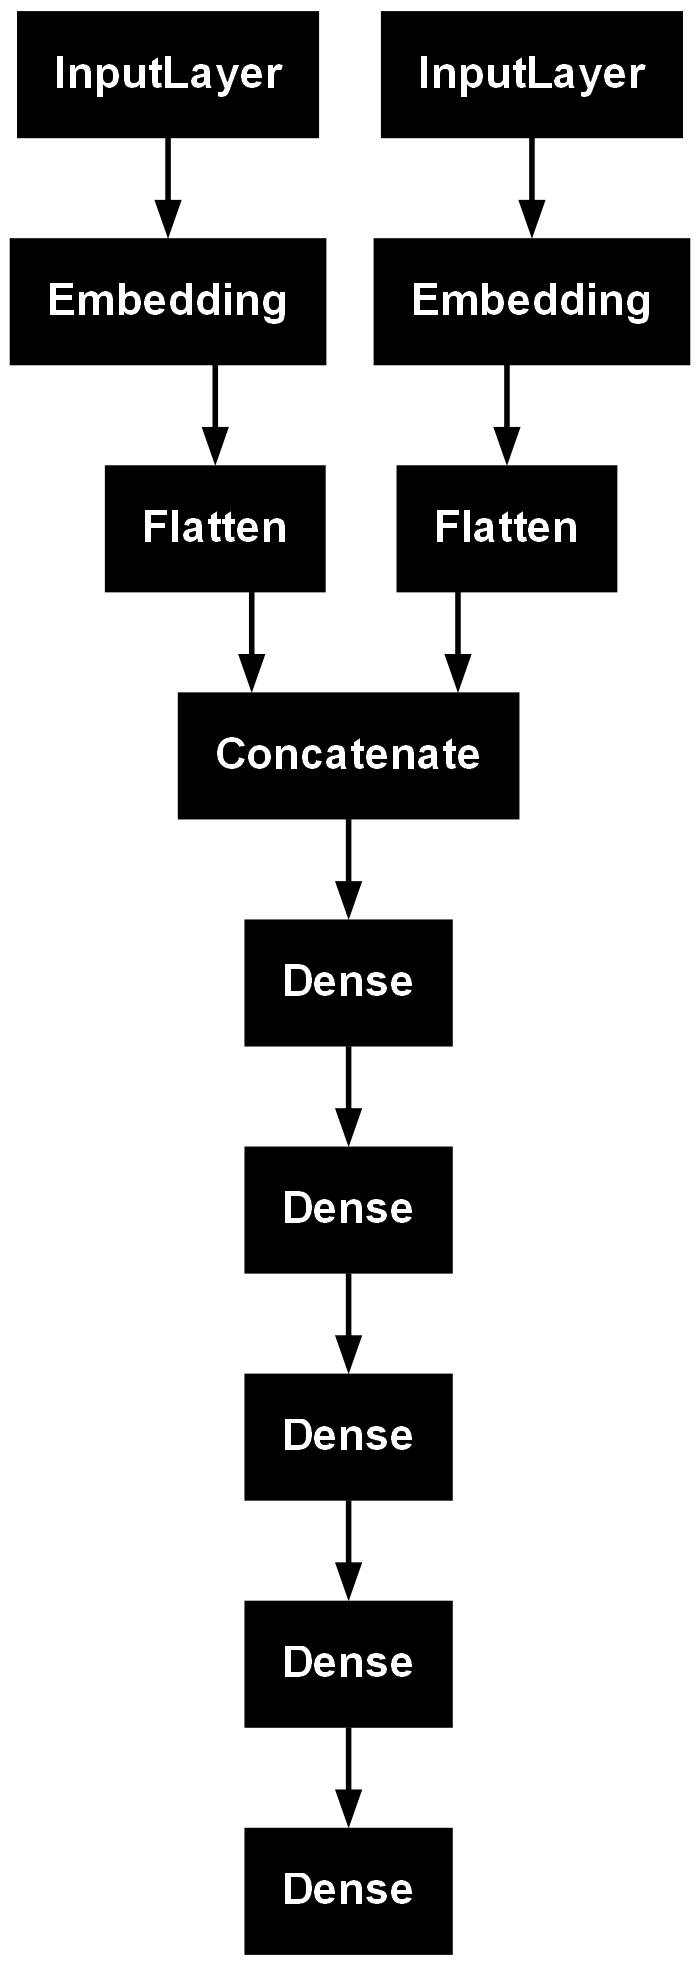

In [19]:
tf.keras.utils.plot_model(model)

In [20]:
# fit the model
history = model.fit(x=[train.userId, train.movieId],
                    y=train.rating,
                    epochs=10, verbose=2,
                    validation_data=([validation.userId, validation.movieId], validation.rating))

Epoch 1/10


d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_10', 'keras_tensor_11']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2521/2521 - 3s - 1ms/step - accuracy: 0.8255 - auc_1: 0.7690 - loss: 0.4087 - val_accuracy: 0.8297 - val_auc_1: 0.7999 - val_loss: 0.3913
Epoch 2/10
2521/2521 - 2s - 786us/step - accuracy: 0.8517 - auc_1: 0.8456 - loss: 0.3491 - val_accuracy: 0.8323 - val_auc_1: 0.7988 - val_loss: 0.3952
Epoch 3/10
2521/2521 - 2s - 814us/step - accuracy: 0.8680 - auc_1: 0.8755 - loss: 0.3159 - val_accuracy: 0.8260 - val_auc_1: 0.7951 - val_loss: 0.4144
Epoch 4/10
2521/2521 - 2s - 793us/step - accuracy: 0.8817 - auc_1: 0.8984 - loss: 0.2866 - val_accuracy: 0.8236 - val_auc_1: 0.7855 - val_loss: 0.4286
Epoch 5/10
2521/2521 - 2s - 837us/step - accuracy: 0.8940 - auc_1: 0.9181 - loss: 0.2577 - val_accuracy: 0.8188 - val_auc_1: 0.7728 - val_loss: 0.4715
Epoch 6/10
2521/2521 - 2s - 800us/step - accuracy: 0.9100 - auc_1: 0.9365 - loss: 0.2265 - val_accuracy: 0.8122 - val_auc_1: 0.7558 - val_loss: 0.5192
Epoch 7/10
2521/2521 - 2s - 803us/step - accuracy: 0.9211 - auc_1: 0.9516 - loss: 0.1979 - val_accuracy: 0.

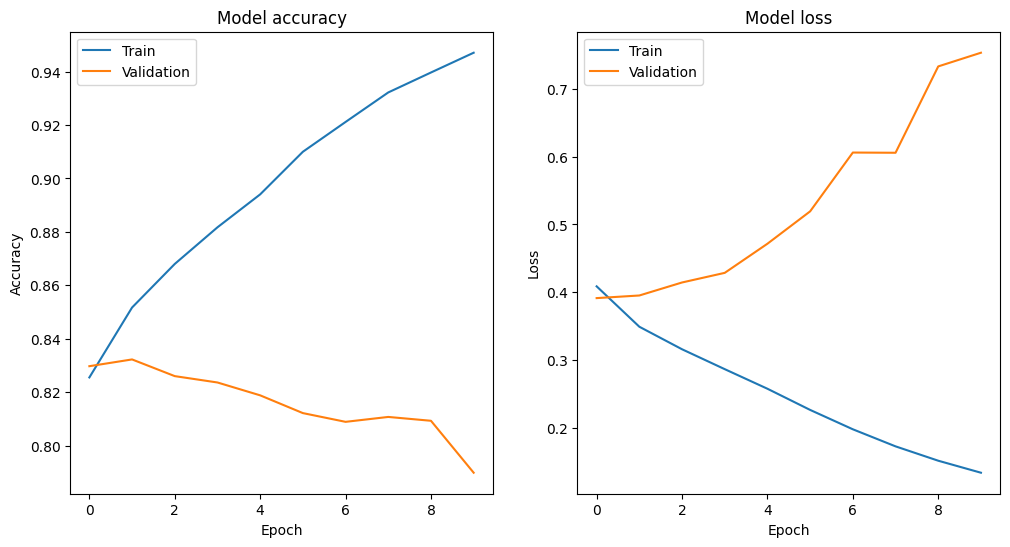

In [21]:
plt.figure(figsize=(12, 6))

# plot training & valdiation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Solving overfitting problem

In [22]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [36]:
# user/item input layers
user_input = Input(shape=(1,))
movie_input = Input(shape=(1,))

# embedding dimensions
n_latent_factors = 20

# embedding layer definition
user_embedding = Embedding(num_unique_users, n_latent_factors, name='user_embedding')(user_input)
movie_embedding = Embedding(num_unique_movies, n_latent_factors, name='mobie_embedding')(movie_input)

# flatten embedding
user_vector = Flatten()(user_embedding)
movie_vector = Flatten()(movie_embedding)

# concat user and movie embedding
concat = Concatenate()([user_vector, movie_vector])

In [37]:
# create a MLP model
output = create_mlp([128, 128], concat)

# final model
model = Model(inputs=[user_input, movie_input], outputs=output)

In [38]:
# compile the model -> evaluate it with auc
auc = tf.keras.metrics.AUC()

learning_rate = 0.005

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy', auc])

In [39]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x=[train.userId, train.movieId],
                    y=train.rating,
                    epochs=10, verbose=2,
                    validation_data=([validation.userId, validation.movieId], validation.rating),
                    callbacks=[early_stopping])

Epoch 1/10


d:\projects\github\learning\recommendation\recommendation\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_52', 'keras_tensor_53']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2521/2521 - 3s - 1ms/step - accuracy: 0.8266 - auc_5: 0.7703 - loss: 0.4076 - val_accuracy: 0.8281 - val_auc_5: 0.7955 - val_loss: 0.3965
Epoch 2/10
2521/2521 - 2s - 811us/step - accuracy: 0.8500 - auc_5: 0.8420 - loss: 0.3524 - val_accuracy: 0.8291 - val_auc_5: 0.7977 - val_loss: 0.3982
Epoch 3/10
2521/2521 - 2s - 801us/step - accuracy: 0.8626 - auc_5: 0.8707 - loss: 0.3222 - val_accuracy: 0.8269 - val_auc_5: 0.7870 - val_loss: 0.4055
Epoch 4/10
2521/2521 - 2s - 804us/step - accuracy: 0.8746 - auc_5: 0.8928 - loss: 0.2961 - val_accuracy: 0.8131 - val_auc_5: 0.7854 - val_loss: 0.4322
Epoch 5/10
2521/2521 - 2s - 791us/step - accuracy: 0.8841 - auc_5: 0.9107 - loss: 0.2717 - val_accuracy: 0.8158 - val_auc_5: 0.7802 - val_loss: 0.4404
Epoch 6/10
2521/2521 - 2s - 832us/step - accuracy: 0.8927 - auc_5: 0.9249 - loss: 0.2499 - val_accuracy: 0.8114 - val_auc_5: 0.7685 - val_loss: 0.4823


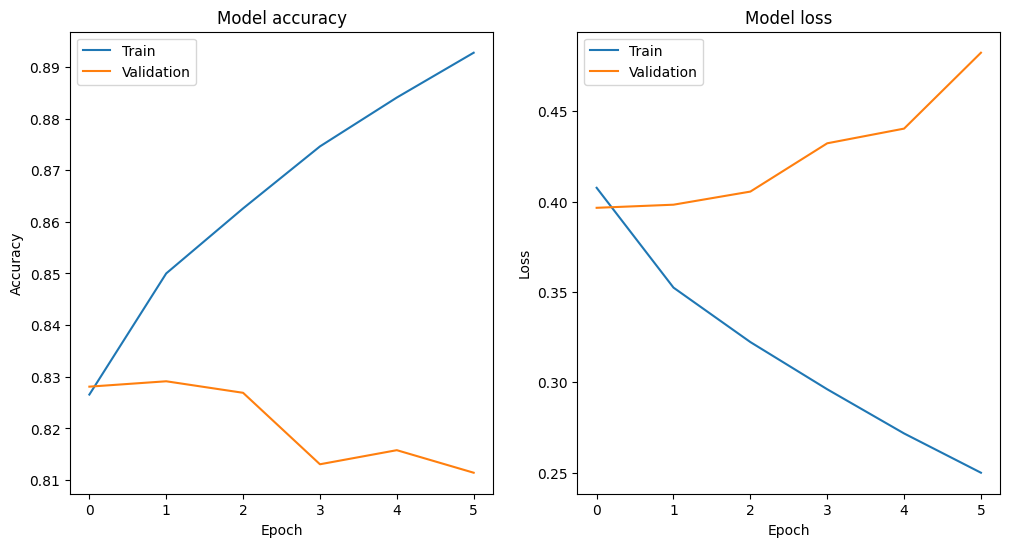

In [40]:
plt.figure(figsize=(12, 6))

# plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [41]:
pd.DataFrame(history.history)

,accuracy,auc_5,loss,val_accuracy,val_auc_5,val_loss
0,0.826561,0.770281,0.407602,0.828094,0.795543,0.396525
1,0.850015,0.841968,0.352363,0.829135,0.797706,0.398248
2,0.862597,0.870740,0.322237,0.826904,0.786998,0.405503
3,0.874597,0.892751,0.296119,0.813070,0.785389,0.432223
4,0.884056,0.910702,0.271673,0.815797,0.780206,0.440352
5,0.892733,0.924882,0.249939,0.811434,0.768499,0.482342
